In [2]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mp

from matplotlib.colors import ListedColormap
from sklearn.datasets import load_boston, load_breast_cancer, load_iris
from sklearn.linear_model import LinearRegression, LogisticRegression, Perceptron, Ridge
from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import PolynomialFeatures

from ml.visualization import plot_confusion_matrix, classifier_boundary

np.random.seed(1234)  # Setup seed to be more deterministic


import pandas as pd

%matplotlib inline

In [37]:
def regresion_lineal(xtf,yt,xvf,yv,regularizacion,alpha,feature):
    if regularizacion==False:
        model = LinearRegression()
        model.fit(xtf, yt)
    else:
        model = Ridge(alpha=alpha)
        model.fit(xtf, yt)
 
    err_train = mean_squared_error(yt, model.predict(xtf))
    err_val = mean_squared_error(yv, model.predict(xvf)) 
        
    return [feature,regularizacion,alpha,err_train,err_val,model.coef_,model.intercept_]


def regresion_polinomial(xtf,yt,xvf,yv,grado_polinomio,regularizacion,alpha,feature):
    poly_features = PolynomialFeatures(grado_polinomio)
    poly_features.fit(xtf)
    X_poly_train = poly_features.transform(xtf)
    X_poly_val = poly_features.transform(xvf)
    
    if regularizacion==False:
        model = LinearRegression()
        model.fit(X_poly_train, y_train)

    else:
        model = Ridge(alpha=alpha)
        model.fit(X_poly_train, y_train)        

    err_train = mean_squared_error(y_train, model.predict(X_poly_train))
    err_val = mean_squared_error(y_val, model.predict(X_poly_val))
    
    return [feature,grado_polinomio,regularizacion,alpha,err_train,err_val,model.coef_,model.intercept_]


def modelo(x,coef,x0):
    ymodel = np.zeros(len(x))
    for i in range(len(x)):
        if len(coef)==1:
            ymodel[i] = coef[0]*x[i]
        else:
            for c in range(len(coef)):
                ymodel[i] = ymodel[i] + coef[c]*x[i]**c
    return ymodel+x0


def plot_fit(feature_resultados,tipo,c,lw):    
    X_range_start = np.min(np.r_[X_train_feature, X_val_feature])
    X_range_stop = np.max(np.r_[X_train_feature, X_val_feature])
    y_range_start = np.min(np.r_[y_train, y_val])
    y_range_stop = np.max(np.r_[y_train, y_val])

    X_linspace = np.linspace(X_range_start, X_range_stop, 200)
    
    # Conjunto de entrenamiento
    plt.scatter(X_train_feature, y_train, facecolor="lightgray", edgecolor="gray", label="datos",s=4.8)
    if tipo=='L':
        for j in range(len(feature_resultados)):
            coef = feature_resultados.Coef.values[j]
            x0 = feature_resultados.Intercept.values[j]
            plt.plot(X_linspace, modelo(X_linspace,coef,x0), color=c, label="modelo",lw=lw)
            plt.title("Conjunto de Entrenamiento Reg-Lin")
    elif tipo=='P':
        grados_= feature_resultados.Degree.unique()
        cc=0
        for g in grados_:
            sub_df = feature_resultados[feature_resultados.Degree==g]
            for j in range(len(sub_df)):
                coef = sub_df.Coef.values[j]
                x0 = sub_df.Intercept.values[j]
                plt.plot(X_linspace, modelo(X_linspace,coef,x0),color=c[cc],label="modelo",lw=1)
                plt.title("Conjunto de Entrenamiento Reg-Pol")
            cc+=1
            
    plt.ylim(y_range_start, y_range_stop)
    
    # Conjunto de validación
    #plt.subplot(1, 2, 2)
    #plt.scatter(X_val_feature, y_val, facecolor="dodgerblue", edgecolor="k", label="datos")
    #plt.plot(X_linspace, model.predict(X_linspace_poly), color="tomato", label="modelo")
    #plt.ylim(y_range_start, y_range_stop)
    #plt.title("Conjunto de Validación")
    
def plot_err(feature_resultados,tipo,c):
    if tipo=='P':
        grados_= feature_resultados.Degree.unique()
        cc=0
        for g in grados_:
            sub_df = feature_resultados[feature_resultados.Degree==g]
            plt.plot(sub_df.Alpha,sub_df.TrainMSE,color=c[cc],label='Grado: '+str(g))
            cc+=1                
        plt.legend(loc='lower right',frameon=False,ncol=3)
    elif tipo=='L':
        plt.plot(feature_resultados.Alpha,feature_resultados.TrainMSE,color=c)
    plt.xlabel('alpha')
    plt.ylabel('ECM')
    
def plot_err_g(feature_resultados,c):
    plt.plot(feature_resultados.Degree,feature_resultados.TrainMSE,color=c)                
    plt.xlabel('Degree')
    plt.ylabel('ECM')

In [4]:
boston_data = load_boston()

In [32]:
regresion_lineal_ECM = pd.DataFrame(columns=['Feature','Regularization','Alpha','TrainMSE', 'ValMSE','Coef','Intercept'])
regresion_polinomial_ECM = pd.DataFrame(columns=['Feature','Degree','Regularization','Alpha','TrainMSE','ValMSE','Coef','Intercept'])


shuff_data = np.random.permutation(506)
shuff_train = shuff_data[:400]
shuff_val = shuff_data[400:]

X_train = boston_data['data'][shuff_train]
X_val = boston_data['data'][shuff_val]

y_train = boston_data['target'][shuff_train]
y_val = boston_data['target'][shuff_val]

feature_map = {feature: idx for idx, feature in enumerate(boston_data['feature_names'])}

features = boston_data['feature_names']
categorical_features = ['CHAS','RAD','MEDV']
non_categorical_features = set(features)-set(categorical_features)

#alpha = np.arange(0.1, 1.1, 0.1)
grado = np.arange(1,10,1)
alpha = np.arange(1e-5,1e3,10)

cmap = mp.cm.get_cmap('Spectral')
color = []
for i in range(len(grado)):
    color.append(cmap(0.1*i))

for feature in non_categorical_features:
    feature_col = feature_map[feature]
    X_train_feature = X_train[:, feature_col].reshape(-1, 1)
    X_val_feature = X_val[:, feature_col].reshape(-1, 1)   

    # regresion lineal
    ## sin regularizacion
    row = regresion_lineal(X_train_feature,y_train,X_val_feature,y_val,False,0,feature)
    
    regresion_lineal_ECM = regresion_lineal_ECM.append(pd.Series(row, index=regresion_lineal_ECM.columns ),ignore_index=True)
    ## con regularizacion
    for i in alpha:
        row = regresion_lineal(X_train_feature,y_train,X_val_feature,y_val,True,i,feature)
        regresion_lineal_ECM = regresion_lineal_ECM.append(pd.Series(row, index=regresion_lineal_ECM.columns ),ignore_index=True)
    

    # regresion polinomial
    ## sin regularizacion
    for g in grado:
        row = regresion_polinomial(X_train_feature,y_train,X_val_feature,y_val,g,False,0,feature)
        regresion_polinomial_ECM = regresion_polinomial_ECM.append(pd.Series(row, index=regresion_polinomial_ECM.columns ),ignore_index=True)
    ## con regularizacion
        for i in alpha:
            row = regresion_polinomial(X_train_feature,y_train,X_val_feature,y_val,g,True,i,feature)
            regresion_polinomial_ECM = regresion_polinomial_ECM.append(pd.Series(row, index=regresion_polinomial_ECM.columns ),ignore_index=True)

/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.85364e-19): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.80382e-23): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.80382e-17): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=3.60764e-17): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=5.41146e-17): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/

/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.10181e-19): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.11988e-19): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.13794e-19): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.156e-19): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.17406e-19): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/an

/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=3.11068e-24): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=3.29366e-24): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=3.47664e-24): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=3.65962e-24): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=3.84261e-24): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/

/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.21469e-23): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.23187e-23): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.24904e-23): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.26622e-23): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.2834e-23): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/a

/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=3.1827e-28): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=3.35472e-28): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=3.52675e-28): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=3.69879e-28): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=3.87084e-28): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/a

/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.21421e-27): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.23146e-27): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.24872e-27): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.26598e-27): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.28324e-27): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/

/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=4.71145e-32): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=4.88536e-32): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=5.05932e-32): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=5.23333e-32): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=5.40739e-32): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/

/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.50104e-31): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.52005e-31): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.53905e-31): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.55805e-31): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.57705e-31): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/

/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=6.59253e-36): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=6.78642e-36): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=6.98032e-36): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=7.17422e-36): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=7.36812e-36): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/

/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.74508e-35): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.76447e-35): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.78386e-35): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.80325e-35): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.82264e-35): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/

/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.24981e-17): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.2757e-17): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.3016e-17): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.50235e-17): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.53125e-17): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/an

/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=6.12657e-22): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=8.14577e-22): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.01756e-21): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.22155e-21): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.42653e-21): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/

/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.3759e-20): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.39962e-20): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.42335e-20): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.44707e-20): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.47079e-20): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/a

/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.88838e-24): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=2.07721e-24): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=2.26605e-24): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=2.45489e-24): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=2.64373e-24): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/

/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.22744e-23): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.24633e-23): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.26521e-23): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.2841e-23): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.30298e-23): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/a

/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=2.58267e-27): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=2.70038e-27): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=2.81807e-27): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=2.93573e-27): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=3.05336e-27): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/

/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=8.7116e-27): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=8.82994e-27): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=8.94831e-27): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=9.0667e-27): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=9.18511e-27): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/an

/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.90455e-18): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.97153e-18): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=2.03852e-18): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=2.1055e-18): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=2.17249e-18): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/a

/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=5.45544e-18): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=5.52245e-18): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=5.58947e-18): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=5.65649e-18): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=5.7235e-18): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/a

/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=4.56307e-21): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=4.70791e-21): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=4.85288e-21): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=4.99798e-21): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=5.14321e-21): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/

/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.4155e-20): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.43216e-20): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.44881e-20): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.46546e-20): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.48212e-20): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/a

/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.20063e-23): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.23109e-23): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.26157e-23): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.29206e-23): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.32265e-23): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/

/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=2.84515e-23): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=2.87556e-23): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=2.90607e-23): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=2.93643e-23): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=2.96685e-23): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/

/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=8.60375e-19): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=8.76308e-19): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=8.92241e-19): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=9.08174e-19): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=9.24107e-19): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/

/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.17222e-23): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.36759e-23): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.56296e-23): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.75833e-23): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.9537e-23): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/a

/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.11959e-22): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.13736e-22): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.15512e-22): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.17289e-22): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.19065e-22): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/

/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=2.10032e-27): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=2.33369e-27): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=2.56706e-27): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=2.80043e-27): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=3.01191e-27): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/

/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.28008e-26): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.30094e-26): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.3218e-26): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.34266e-26): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.36352e-26): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/a

/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=2.71197e-31): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=2.95003e-31): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=3.18818e-31): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=3.42642e-31): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=3.66474e-31): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/

/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.52003e-30): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.54426e-30): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.56848e-30): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.59272e-30): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.61696e-30): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/

/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=2.97491e-35): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=3.2453e-35): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=3.51604e-35): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=3.78714e-35): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=4.05859e-35): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/a

/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.74822e-34): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.77944e-34): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.81066e-34): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.84188e-34): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.8731e-34): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/a

/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=5.58346e-17): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=4.75964e-19): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=3.80088e-21): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=2.9036e-23): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=2.47096e-17): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/a

/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=6.68857e-18): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=6.84917e-18): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=7.0097e-18): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=7.17017e-18): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=7.33058e-18): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/a

/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.89377e-17): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.91529e-17): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.93681e-17): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.95833e-17): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.97985e-17): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/

/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=8.21896e-17): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=8.39763e-17): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=8.5763e-17): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=8.75498e-17): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=8.93365e-17): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/a

/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=9.00962e-23): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=9.37e-23): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=9.73039e-23): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.00908e-22): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.04512e-22): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/ana

/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=2.63081e-22): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=2.66685e-22): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=2.70289e-22): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=2.73892e-22): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=2.77496e-22): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/

/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.45499e-28): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.53157e-28): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.60815e-28): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.68473e-28): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.76131e-28): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/

/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=5.13077e-28): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=5.20735e-28): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=5.28392e-28): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=5.3605e-28): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=5.43708e-28): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/a

/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.83254e-34): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.9981e-34): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=2.16356e-34): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=2.32903e-34): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=2.4945e-34): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/an

/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=9.44412e-34): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=9.60958e-34): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=9.77505e-34): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=9.94052e-34): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.0106e-33): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/a

/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=7.27683e-41): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.09112e-40): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.45456e-40): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.81801e-40): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=2.18145e-40): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/

/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.78097e-39): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.81731e-39): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.85366e-39): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.89e-39): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.92635e-39): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/ana

/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=3.30748e-39): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=3.34383e-39): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=3.38017e-39): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=3.41652e-39): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=3.45287e-39): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/

/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=2.75595e-45): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=2.83701e-45): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=2.91807e-45): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=2.99913e-45): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=3.08018e-45): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/

/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=6.4846e-45): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=6.56565e-45): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=6.64671e-45): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=6.72777e-45): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=6.80882e-45): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/a

/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=4.24629e-51): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=3.27231e-51): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=4.67109e-51): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=2.73042e-51): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=4.66995e-51): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/

/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.1963e-50): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.22167e-50): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.23964e-50): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.2576e-50): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.15839e-50): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/an

/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.33338e-17): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=7.52487e-23): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=7.52488e-17): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=4.40497e-28): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=4.40497e-22): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/

/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=2.02629e-20): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=2.07033e-20): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=2.11438e-20): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=2.15843e-20): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=2.20248e-20): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/

/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=3.92042e-20): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=3.96447e-20): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=4.00852e-20): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=4.05257e-20): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=4.09662e-20): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/

/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.15533e-25): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.18159e-25): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.20785e-25): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.2341e-25): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.26036e-25): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/a

/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=2.59949e-25): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.58375e-38): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.58375e-32): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=3.1675e-32): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=4.75125e-32): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/a

/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=8.07712e-31): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=8.2355e-31): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=8.39387e-31): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=8.55225e-31): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=8.71062e-31): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/a

/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=9.63426e-44): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=9.63427e-38): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.92685e-37): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=2.89028e-37): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=3.8537e-37): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/a

/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=5.00981e-36): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=5.10616e-36): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=5.2025e-36): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=5.29884e-36): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=5.39518e-36): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/a

/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=2.35948e-42): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=2.94935e-42): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=3.53923e-42): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=4.1291e-42): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=4.71897e-42): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/a

/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=3.48024e-41): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=3.53923e-41): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=3.59821e-41): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=3.6572e-41): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=3.71619e-41): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/a

/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=2.90392e-47): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=3.26691e-47): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=3.6299e-47): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=3.99289e-47): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=4.35588e-47): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/a

/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.92385e-46): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.96015e-46): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.99645e-46): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=2.03275e-46): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=2.06904e-46): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/

/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=3.52101e-46): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=3.55731e-46): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=3.5936e-46): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.26219e-17): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.87304e-21): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/a

/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.12578e-17): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.15196e-17): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.17814e-17): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.20432e-17): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.2305e-17): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/a

/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.41349e-22): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.76686e-22): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=2.12023e-22): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=2.47361e-22): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=2.82698e-22): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/

/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.62551e-21): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.66085e-21): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.69619e-21): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.73152e-21): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.76686e-21): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/

/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=3.14501e-21): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=3.18035e-21): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=3.21569e-21): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=3.25103e-21): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=3.28636e-21): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/

/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=2.42531e-25): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=2.4696e-25): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=2.50943e-25): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=2.54927e-25): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=2.58911e-25): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/a

/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=4.10706e-25): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=4.14711e-25): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=4.18716e-25): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=4.22722e-25): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=4.26728e-25): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/

/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=2.94872e-29): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=2.99994e-29): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=3.05119e-29): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=3.10246e-29): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=3.15375e-29): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/

/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=5.11707e-29): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=5.1691e-29): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=5.22115e-29): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=5.27321e-29): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=5.32529e-29): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/a

/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=3.8985e-33): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=3.96594e-33): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=4.03344e-33): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=4.10101e-33): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=4.16864e-33): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/a

/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=3.00042e-18): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=5.06104e-21): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=7.87983e-24): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=7.87984e-18): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.45393e-17): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/

/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=3.94659e-19): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=4.06266e-19): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=4.17874e-19): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=4.29482e-19): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=4.41089e-19): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/

/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=9.98254e-19): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.00986e-18): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.02147e-18): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.03308e-18): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.04468e-18): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/

/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=5.94651e-22): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=6.077e-22): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=6.20751e-22): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=6.33802e-22): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=6.46854e-22): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/an

/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.31515e-21): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.32831e-21): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=2.30077e-32): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=2.30077e-26): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=4.60153e-26): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/

/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=8.55838e-25): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=8.74393e-25): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=8.92971e-25): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=9.1157e-25): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=9.30191e-25): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/a

AGE


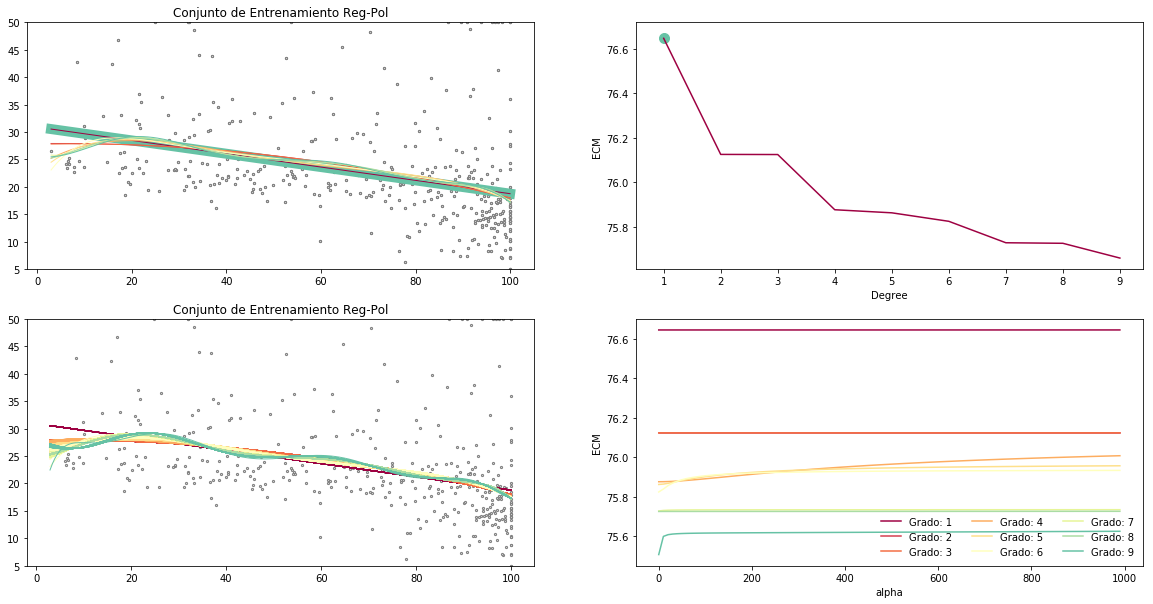

LSTAT


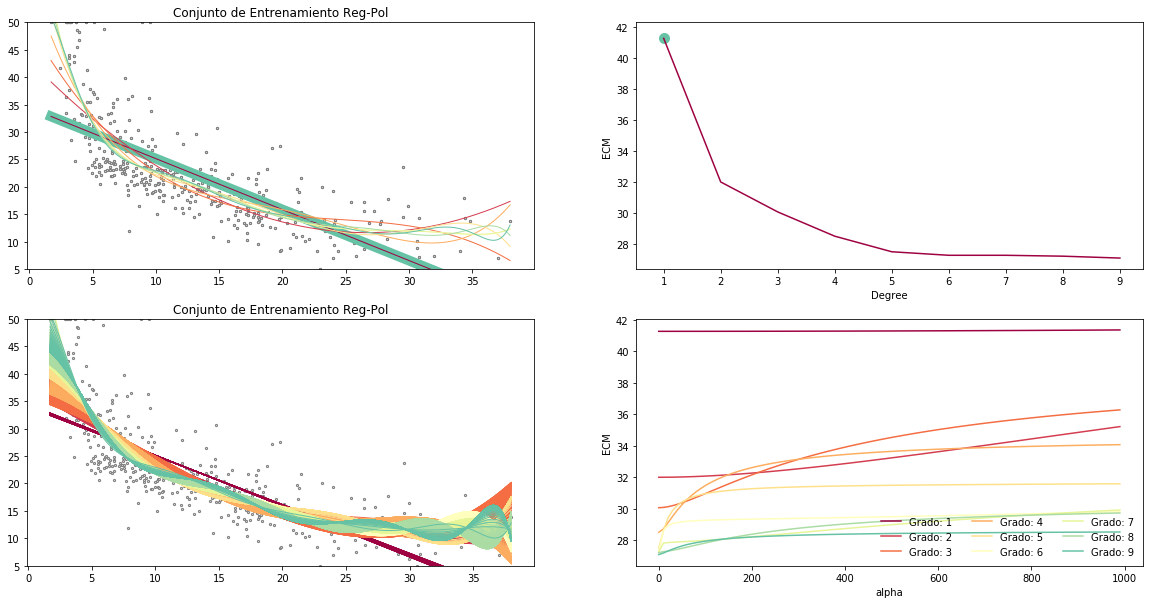

PTRATIO


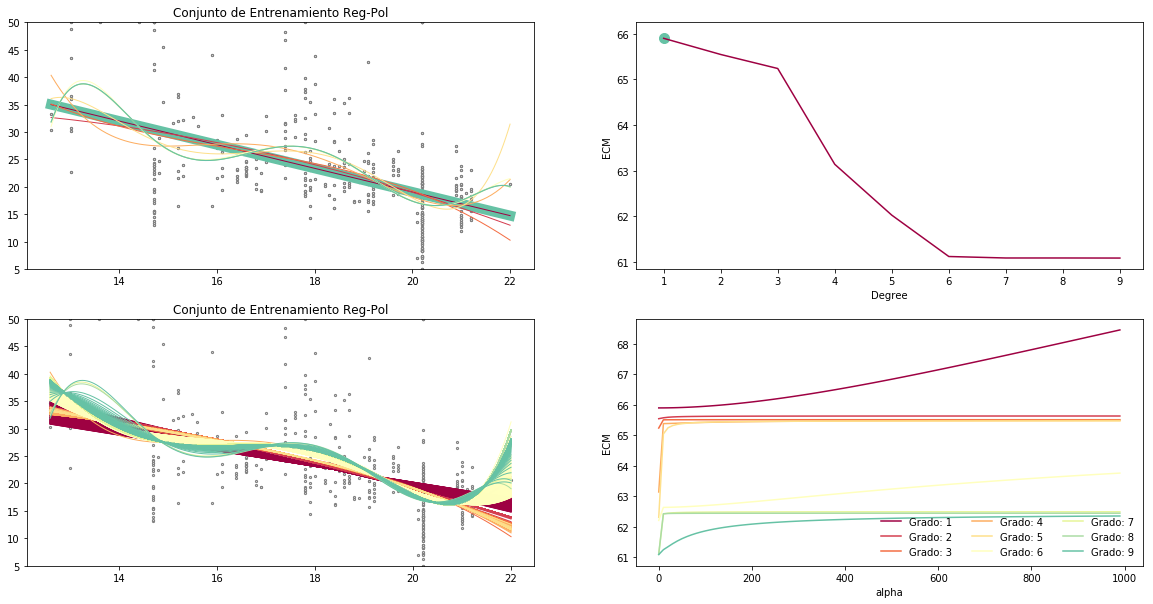

ZN


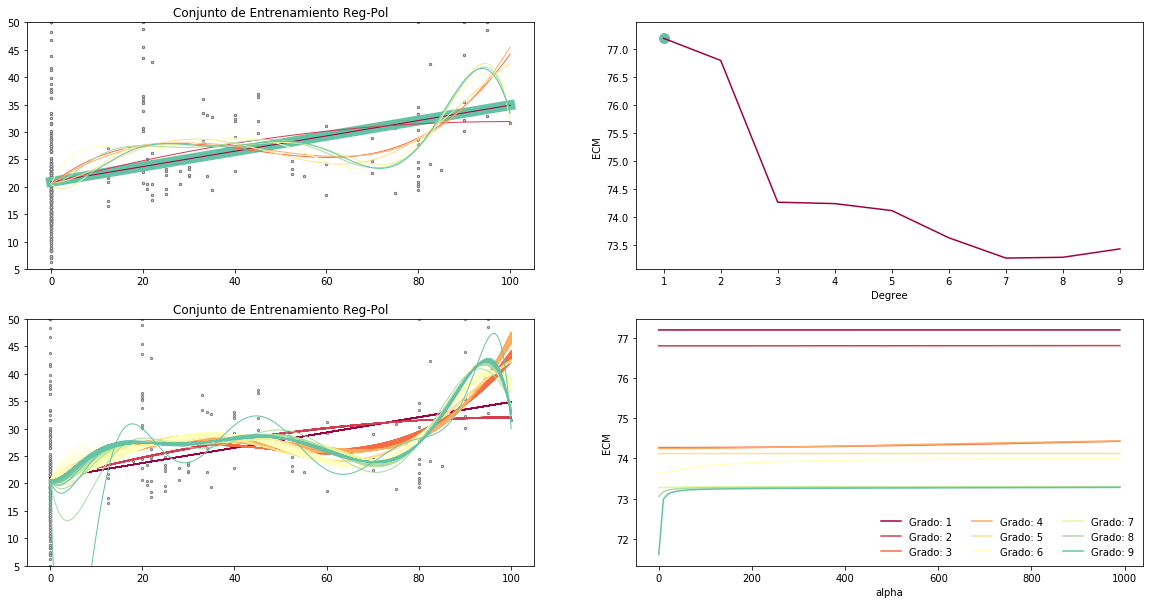

DIS


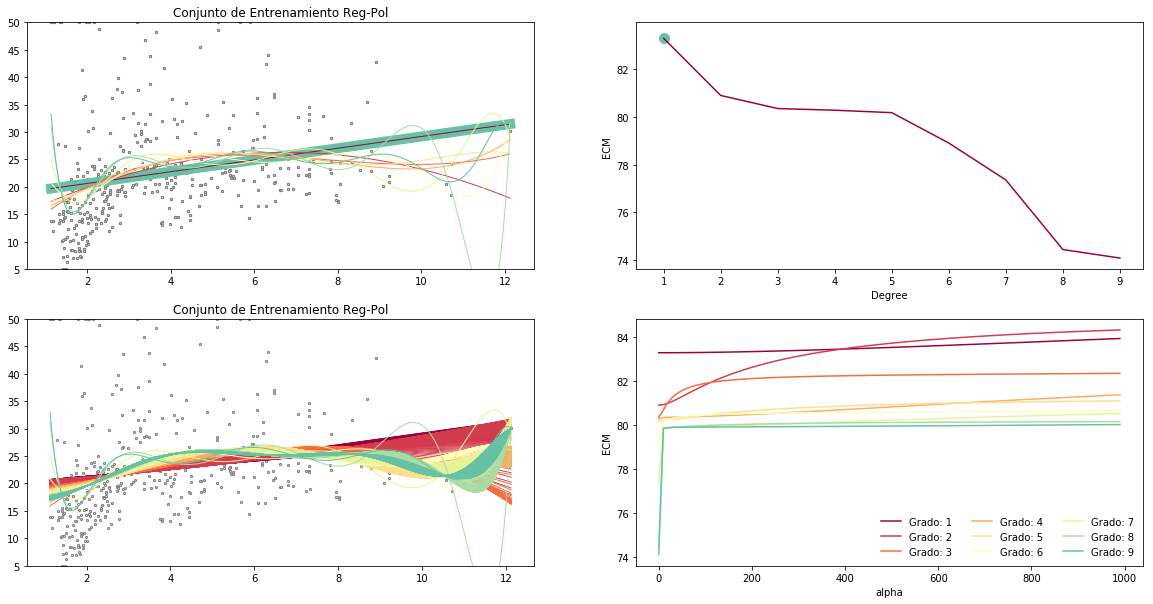

TAX


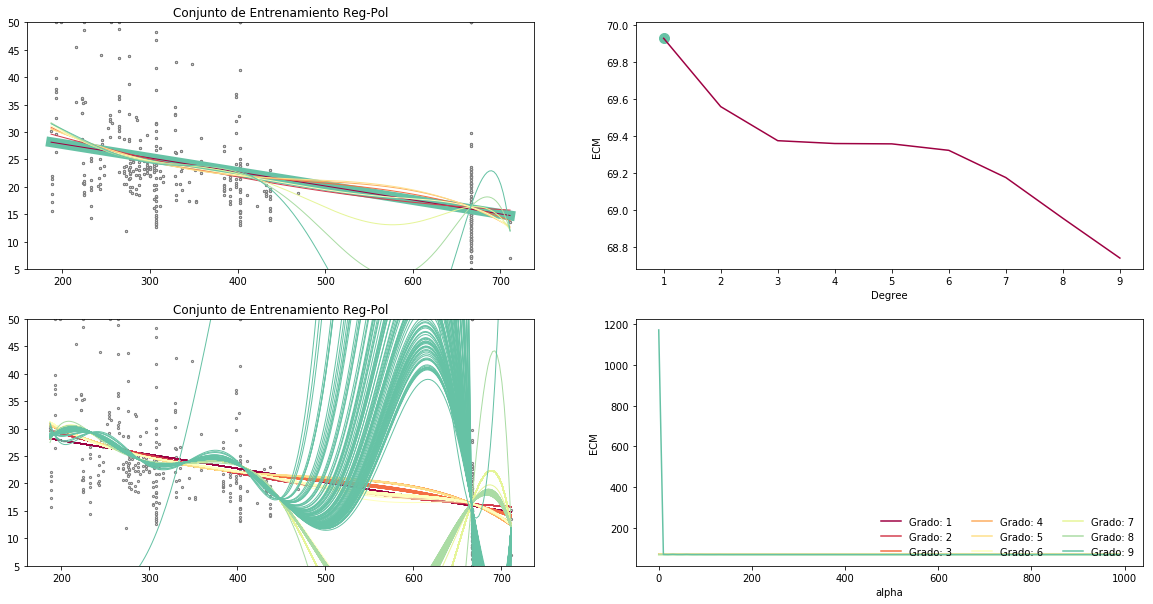

RM


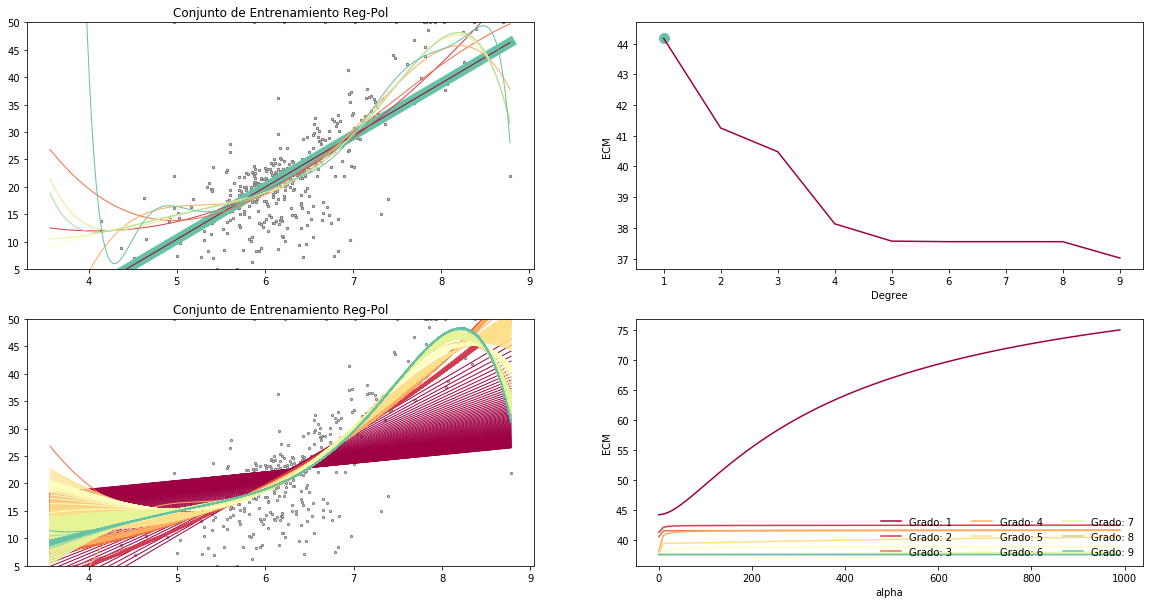

B


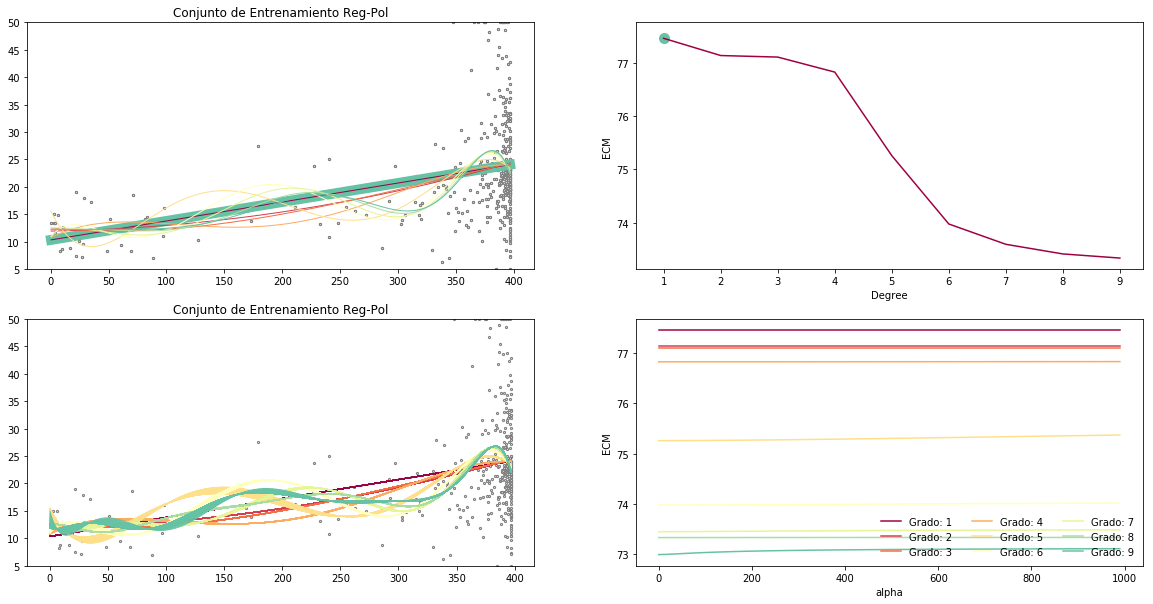

CRIM


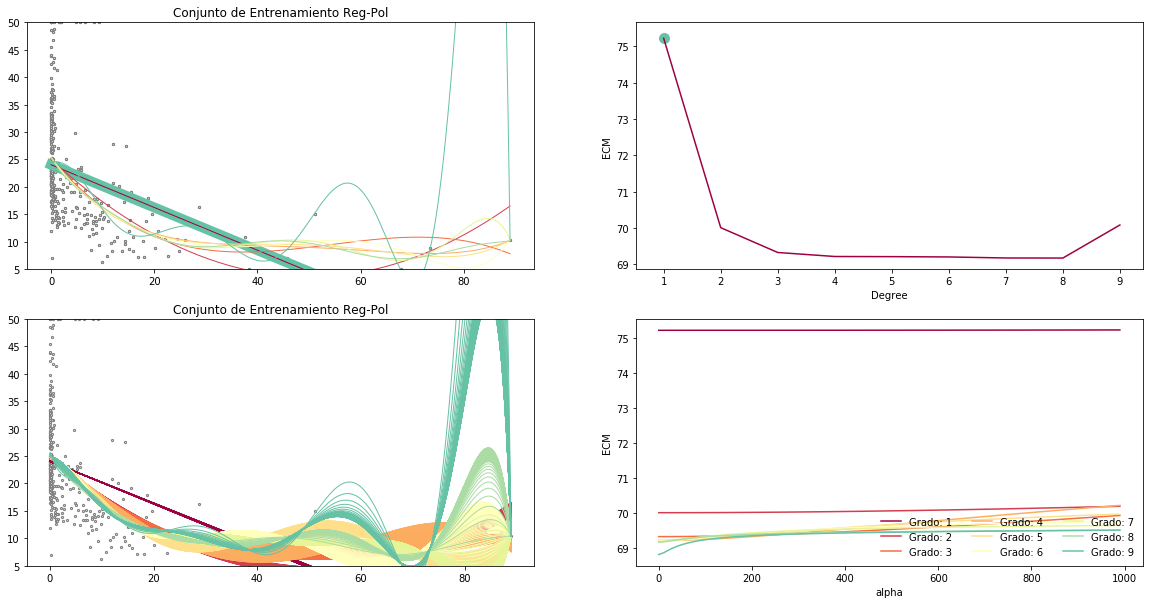

NOX


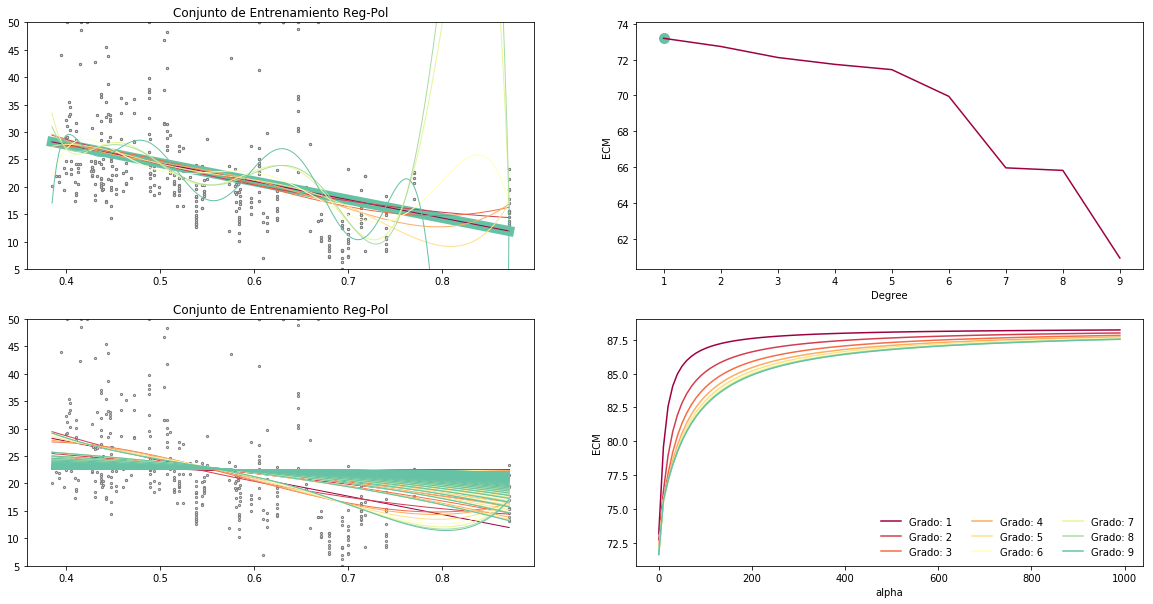

INDUS


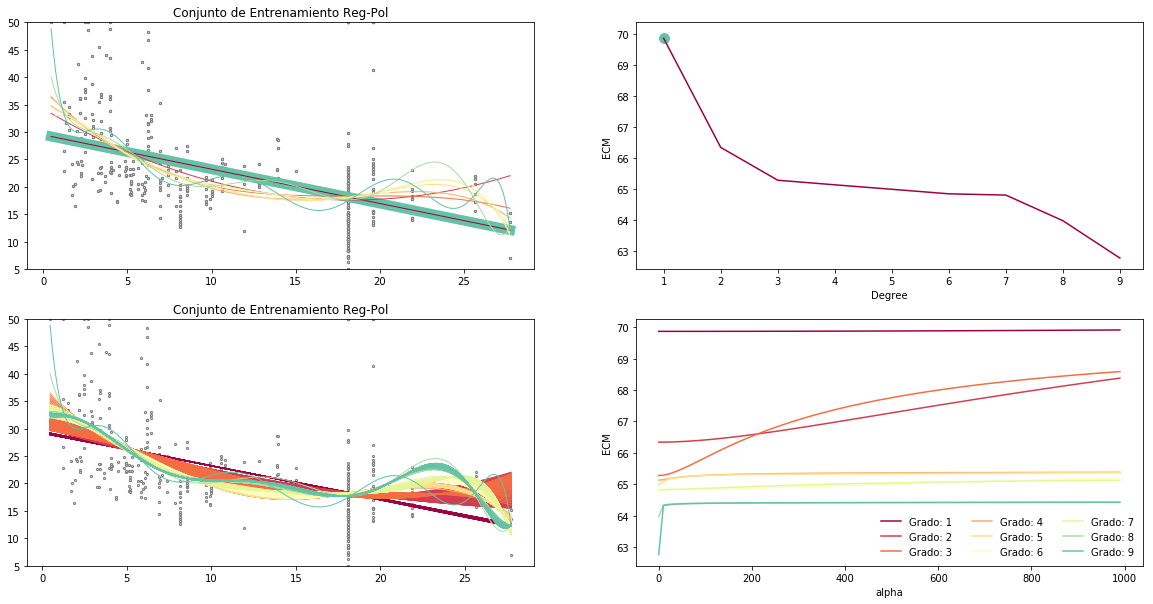

In [54]:
diferencias=[]
for feature in non_categorical_features:
    print(feature)
    feature_col = feature_map[feature]
    X_train_feature = X_train[:, feature_col].reshape(-1, 1)
    X_val_feature = X_val[:, feature_col].reshape(-1, 1)   

    plt.figure(figsize=(20,10))
    
    feature_resultadosl = regresion_lineal_ECM[(regresion_lineal_ECM.Feature==feature)&
                                               (regresion_lineal_ECM.Regularization==False)]
    punto_err_metodo_lineal = [1,feature_resultadosl.TrainMSE.values[0]]
    
    #plt.subplot(421)
    
    feature_resultados = regresion_polinomial_ECM[(regresion_polinomial_ECM.Feature==feature)&
                                                 (regresion_polinomial_ECM.Regularization==False)]
    plt.subplot(221)
    plot_fit(feature_resultadosl,'L',color[-1],lw=10)
    plot_fit(feature_resultados,'P',color,lw=1)
    
    feature_resultados = regresion_polinomial_ECM[(regresion_polinomial_ECM.Alpha==0)&
                                                  (regresion_polinomial_ECM.Feature==feature)]

    diferencias.append(punto_err_metodo_lineal[1]-feature_resultados.TrainMSE.values[0])
    
    plt.subplot(222)
    plot_err_g(feature_resultados,color[0])
    plt.scatter(punto_err_metodo_lineal[0],punto_err_metodo_lineal[1],color=color[-1],s=100)
    
    
    
    
    feature_resultados = regresion_lineal_ECM[(regresion_lineal_ECM.Feature==feature)&
                                             (regresion_lineal_ECM.Regularization==True)]
    
    #plt.subplot(323)
    #plot_fit(feature_resultados,'L',color[0],lw=1)
    #plt.subplot(324)
    #plot_err(feature_resultados,'L',color[0])
    
    feature_resultados = regresion_polinomial_ECM[(regresion_polinomial_ECM.Feature==feature)&
                                                 (regresion_polinomial_ECM.Regularization==True)]
    plt.subplot(223)
    plot_fit(feature_resultados,'P',color,lw=1)
    plt.subplot(224)
    plot_err(feature_resultados,'P',color)
    
    plt.show()

In [53]:
diferencias

[-1.4210854715202004e-14,
 0.0,
 0.0,
 0.0,
 -1.4210854715202004e-14,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

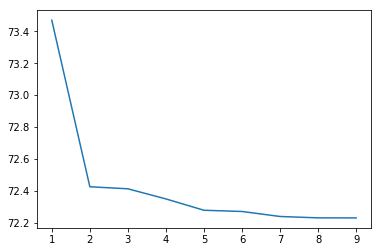

In [20]:
db=regresion_polinomial_ECM.copy()
DB = db[(db.Alpha==0)&(db.Feature=='AGE')]
plt.plot(DB.Degree,DB.TrainMSE)

In [41]:
DB.TrainMSE.values[0]

73.46947468296865

In [51]:
regresion_lineal_ECM[(regresion_lineal_ECM.Feature==feature)&
                                               (regresion_lineal_ECM.Regularization==False)].TrainMSE.values[0]

69.86770194651145

In [49]:
regresion_lineal_ECM.columns

Index(['Feature', 'Regularization', 'Alpha', 'TrainMSE', 'ValMSE', 'Coef',
       'Intercept'],
      dtype='object')